<font size="7">Knowledge Graph-Based Medical Discovery Pipeline</font>

<font size="4">This notebook implements the standard KG-based medical knowledge discovery pipeline as described in Figure 1a of the Scorpius paper (Wang et al., 2024). This pipeline demonstrates how medical knowledge is extracted from literature, represented as a knowledge graph, and used to rank drugs for disease treatment.</font>



CSE 428 Computational Biology - Capstone Project
Figure 1a: Standard KG-based Medical Knowledge Discovery Pipeline

Based on the paper:
Wang, S., et al. (2024). "Poisoning medical knowledge using large language models." 
Nature Machine Intelligence, 6(10), 1156-1168. 
DOI: 10.1038/s42256-024-00899-3
GitHub Repository: https://github.com/yjwtheonly/Scorpius

This implementation specifically focuses on the disease-specific pipeline
as described in Figure 1a of the paper.





In [2]:
# CSE 428 Computational Biology - Capstone Project
# Figure 1a: Standard KG-based Medical Knowledge Discovery Pipeline
# Based on the Scorpius paper (Wang et al., 2024)

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle as pkl
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def seed_all(seed=1):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


<font size="6">1. Data Loading and Preprocessing</font>

<font size="4"> The first step to the data loading and preprocessing is loading medical literature data. This will include the triplets which will represent medical knowledge (subject-relation-object). If this is for actual use then this data would be extracted from medical papers using natural language processing techniques. Here for the scorpius paper, this is shown as "Collection of medical papers" which is represented in figure 1a of this research paper. </font>

In [4]:
# 1. Data Loading

def load_data(file_name, drop=True):
    """Load data from a tab-separated file."""
    try:
        df = pd.read_csv(file_name, sep='\t', header=None, names=None, dtype=str)
        if drop:
            df = df.drop_duplicates()
        return df.values
    except FileNotFoundError:
        print(f"Warning: File {file_name} not found. Creating dummy data for demonstration.")
        dummy_data = np.array([
            ['1', '10', '100'],
            ['2', '11', '101'],
            ['3', '12', '102'],
            ['4', '13', '103'],
            ['5', '14', '104']
        ])
        return dummy_data

def generate_dicts(data_path):
    """Generate entity and relation dictionaries from the data."""
    try:
        with open(os.path.join(data_path, 'entities_dict.json'), 'r') as f:
            ent_to_id = json.load(f)
        with open(os.path.join(data_path, 'relations_dict.json'), 'r') as f:
            rel_to_id = json.load(f)
    except FileNotFoundError:
        print(f"Warning: Dictionary files not found in {data_path}. Creating dummy dictionaries.")
        ent_to_id = {f"entity_{i}": str(i) for i in range(1000)}
        rel_to_id = {f"relation_{i}": str(i) for i in range(36)}
    
    n_ent = len(list(ent_to_id.keys()))
    n_rel = len(list(rel_to_id.keys()))
    
    return n_ent, n_rel, ent_to_id, rel_to_id

data_path = os.path.join('processed_data', 'GNBR')

n_ent, n_rel, ent_to_id, rel_to_id = generate_dicts(data_path)
print(f"Number of entities: {n_ent}")
print(f"Number of relations: {n_rel}")

all_triplets = load_data(os.path.join(data_path, 'all.txt'))
print(f"Number of triplets in the KG: {len(all_triplets)}")

print("\nExample triplets:")
for i in range(min(5, len(all_triplets))):
    s, r, o = all_triplets[i]
    print(f"Subject: {s}, Relation: {r}, Object: {o}")

Number of entities: 10
Number of relations: 5
Number of triplets in the KG: 5

Example triplets:
Subject: 1000, Relation: 10, Object: 5000
Subject: 1001, Relation: 11, Object: 5001
Subject: 2000, Relation: 12, Object: 1002
Subject: 2001, Relation: 13, Object: 1003
Subject: 2002, Relation: 20, Object: 1004


<font size="5">2. Knowledge Graph Construction</font>

<font size="4"> The second step is constructing a knowledge graph that is from the extracted triplets. This step process will involve in 
recognizing entities such as drugs, diseases, genes, and their relationships from the text using dependency parsing. This part is very 
imperative for this Scorpius paper because this is where the problem of poisoning attacks could potentionally introduces malicious links.</font>

In [6]:
# 2. Knowledge Graph Construction
# This section demonstrates the concept of relation extraction

class SimplifiedKGConstructor:
    """
    A simplified KG constructor that demonstrates the concept without requiring 
    the original pickle files.
    """
    def __init__(self):
        self.relation_types = {
            '10': 'treats',
            '11': 'causes',
            '12': 'associated_with',
            '13': 'interacts_with',
            '14': 'expressed_in'
        }
        
        self.dependency_patterns = {
            'treats': [
                "DRUG | nsubj | treats | dobj | DISEASE",
                "DRUG | nsubj | effective | prep_for | DISEASE",
                "DRUG | nsubj | used | prep_for | DISEASE"
            ],
            'causes': [
                "DISEASE | nsubj | caused | agent | GENE",
                "GENE | nsubj | leads | prep_to | DISEASE",
                "GENE | nsubj | associated | prep_with | DISEASE"
            ]
        }
        
        self.example_sentences = {
            "DRUG | nsubj | treats | dobj | DISEASE": 
                "Metformin treats type 2 diabetes effectively.",
            "DRUG | nsubj | effective | prep_for | DISEASE":
                "Ibuprofen is effective for relieving inflammation.",
            "DISEASE | nsubj | caused | agent | GENE":
                "Cystic fibrosis is caused by mutations in the CFTR gene."
        }
    
    def get_relation_name(self, relation_id):
        """Get the human-readable name of a relation."""
        return self.relation_types.get(relation_id, f"unknown_relation_{relation_id}")
    
    def get_entity_name(self, entity_id):
        """Dummy function to return an entity name."""
        entity_types = {
            '1': 'Metformin (drug)',
            '2': 'BRCA1 (gene)',
            '3': 'Diabetes (disease)',
            '4': 'Ibuprofen (drug)',
            '5': 'Cancer (disease)'
        }
        return entity_types.get(entity_id, f"Entity_{entity_id}")
    
    def extract_relation_examples(self, relation_id, max_examples=3):
        """Extract example sentences containing a specific relation."""
        relation_name = self.get_relation_name(relation_id)
        
        patterns = self.dependency_patterns.get(relation_name, [])
        examples = []
        
        for pattern in patterns[:max_examples]:
            if pattern in self.example_sentences:
                examples.append({
                    'text': self.example_sentences[pattern],
                    'dependency_path': pattern,
                    'start_entity': pattern.split(' | ')[0],
                    'end_entity': pattern.split(' | ')[-1]
                })
        
        while len(examples) < max_examples:
            examples.append({
                'text': f"This is a dummy example for relation {relation_name}.",
                'dependency_path': "ENTITY1 | relation | ENTITY2",
                'start_entity': "ENTITY1",
                'end_entity': "ENTITY2"
            })
                    
        return examples

kg_constructor = SimplifiedKGConstructor()

import random
example_idx = random.randint(0, len(all_triplets)-1)
example_triplet = all_triplets[example_idx]
s, r, o = example_triplet

s_name = kg_constructor.get_entity_name(s)
o_name = kg_constructor.get_entity_name(o)
relation_name = kg_constructor.get_relation_name(r)

print(f"Example triplet: Subject={s} ({s_name}), Relation={r} ({relation_name}), Object={o} ({o_name})")

relation_examples = kg_constructor.extract_relation_examples(r)
print("\nExample sentences containing this relation type:")
for i, example in enumerate(relation_examples):
    print(f"Example {i+1}:")
    print(f"Text: {example['text']}")
    print(f"Start entity: {example['start_entity']}")
    print(f"End entity: {example['end_entity']}")
    print(f"Dependency path: {example['dependency_path']}")
    print()

Example triplet: Subject=1000 (Entity_1000), Relation=10 (treats), Object=5000 (Entity_5000)

Example sentences containing this relation type:
Example 1:
Text: Metformin treats type 2 diabetes effectively.
Start entity: DRUG
End entity: DISEASE
Dependency path: DRUG | nsubj | treats | dobj | DISEASE

Example 2:
Text: Ibuprofen is effective for relieving inflammation.
Start entity: DRUG
End entity: DISEASE
Dependency path: DRUG | nsubj | effective | prep_for | DISEASE

Example 3:
Text: This is a dummy example for relation treats.
Start entity: ENTITY1
End entity: ENTITY2
Dependency path: ENTITY1 | relation | ENTITY2



<font size="5">3. Knowledge Graph Reasoning</font> 

<font size="4"> Now that I have already constructed the graph, the embedding techniques will be use so that it can epresent entities and relations in a continuous vector space. I decided to implement the class Dismult model because this part was being talked about in the research paper of Scorpius. This implementation show how model assigns embedding vectors to each entity and relation, which will then allow it to predict missing links that is in the graph. </font> 


<font size="5">4. Drug Ranking Predictions</font>

<font size="4"> Embeddings had been used to make predictions. This is explicitly for drugs ranking in order to treat a specific disease. This is to be represented as the central application of knowledge graphs for medical knowledge discovery. This also includes the target that poisoning attacks aim to manipulate.  </font>

<font size="4"> Based on figure 1a, this step is illustrated by the "Ranking" arrow going from the embedding space to the final resulting ranking of drugs. </font>

In [8]:
# 3. Knowledge Graph Reasoning
# Implementing the DistMult model from the Scorpius paper (Wang et al., 2024)
# This code is adapted from the disease-specific folder in their GitHub repository

class Distmult(torch.nn.Module):
    def __init__(self, n_entities, n_relations, embedding_dim=128, input_drop=0.2):
        super(Distmult, self).__init__()
        
        self.emb_e = torch.nn.Embedding(n_entities, embedding_dim, padding_idx=None)
        self.emb_rel = torch.nn.Embedding(n_relations, embedding_dim, padding_idx=None)
        
        self.inp_drop = torch.nn.Dropout(input_drop)
        self.loss = torch.nn.CrossEntropyLoss()
        
        self.init()
    
    def init(self):
        torch.nn.init.xavier_normal_(self.emb_e.weight)
        torch.nn.init.xavier_normal_(self.emb_rel.weight)
    
    def forward(self, sub_emb, rel_emb, mode='rhs', sigmoid=False):
        '''
        When mode is 'rhs' we expect (s,r); for 'lhs', we expect (o,r)
        '''
        sub_emb = self.inp_drop(sub_emb)
        rel_emb = self.inp_drop(rel_emb) 
        
        pred = torch.mm(sub_emb*rel_emb, self.emb_e.weight.transpose(1,0))
            
        if sigmoid:
            pred = torch.sigmoid(pred)

        return pred
    
    def score_sr(self, sub, rel, sigmoid=False):
        """Score all possible objects for a given (subject, relation) pair."""
        sub_emb = self.emb_e(sub).squeeze(dim=1)
        rel_emb = self.emb_rel(rel).squeeze(dim=1)
            
        pred = torch.mm(sub_emb*rel_emb, self.emb_e.weight.transpose(1,0))
        if sigmoid:
            pred = torch.sigmoid(pred) 
        return pred
    
    def score_or(self, obj, rel, sigmoid=False):
        """Score all possible subjects for a given (object, relation) pair."""
        obj_emb = self.emb_e(obj).squeeze(dim=1)
        rel_emb = self.emb_rel(rel).squeeze(dim=1)
        
        pred = torch.mm(obj_emb*rel_emb, self.emb_e.weight.transpose(1,0))
        if sigmoid:
            pred = torch.sigmoid(pred)
        return pred
    
    def score_triples(self, sub, rel, obj, sigmoid=False):
        """Calculate scores for a batch of triples."""
        sub_emb = self.emb_e(sub).squeeze(dim=1)
        rel_emb = self.emb_rel(rel).squeeze(dim=1)
        obj_emb = self.emb_e(obj).squeeze(dim=1)
        
        pred = torch.sum(sub_emb*rel_emb*obj_emb, dim=-1)
        
        if sigmoid:
            pred = torch.sigmoid(pred)

        return pred

def create_simplified_model(n_ent, n_rel, embedding_dim=128, device=torch.device("cpu")):
    """Create a pre-initialized model for demonstration purposes."""
    print("Creating a simplified model for demonstration...")
    
    model = Distmult(n_ent, n_rel, embedding_dim).to(device)
    model.eval()  
    
    return model

model = create_simplified_model(n_ent, n_rel, embedding_dim=128, device=device)
print("Model created successfully")


# 4. Drug Ranking Predictions
def get_drug_rankings_for_disease(model, disease_id, n_ent, device, entityid_to_nodetype=None):
    """
    Calculate the ranking of drugs for treating a specific disease.
    Returns the sorted list of (drug_id, score) pairs.
    """
    with torch.no_grad():

        disease_tensor = torch.tensor([[int(disease_id) % n_ent]], dtype=torch.long).to(device)
        
        treatment_rel = torch.tensor([[10 % n_rel]], dtype=torch.long).to(device)
        
        scores = model.score_or(disease_tensor, treatment_rel).squeeze()
        
        sorted_scores, sorted_indices = torch.sort(scores, descending=True)
        
        result = [(idx.item(), score.item()) for idx, score in zip(sorted_indices, sorted_scores)]
        
        if entityid_to_nodetype is not None:
            filtered_result = []
            for idx, score in result:
                if str(idx) in entityid_to_nodetype and entityid_to_nodetype[str(idx)] == 'drug':
                    filtered_result.append((idx, score))
            if filtered_result:
                result = filtered_result[:20]  
        
        return result[:10]  

try:
    try:
        with open(os.path.join(data_path, 'entityid_to_nodetype.json'), 'r') as fl:
            entityid_to_nodetype = json.load(fl)
    except:
        print("Entity type information not available, using all entities for ranking.")
        entityid_to_nodetype = None
    
    disease_id = "3"  
    disease_name = kg_constructor.get_entity_name(disease_id)
    
    print(f"\nGetting drug rankings for disease: {disease_name} (ID: {disease_id})")
    rankings = get_drug_rankings_for_disease(model, disease_id, n_ent, device, entityid_to_nodetype)
    
    print("\nTop drugs for this disease:")
    for i, (drug_id, score) in enumerate(rankings[:10]):
        drug_name = kg_constructor.get_entity_name(str(drug_id))
        print(f"Rank {i+1}: {drug_name} (ID: {drug_id}) - Score: {score:.4f}")
        
except Exception as e:
    print(f"Error in ranking calculation: {e}")

Creating a simplified model for demonstration...
Model created successfully

Getting drug rankings for disease: Diabetes (disease) (ID: 3)

Top drugs for this disease:
Rank 1: Cancer (disease) (ID: 5) - Score: 0.0183
Rank 2: BRCA1 (gene) (ID: 2) - Score: 0.0080
Rank 3: Metformin (drug) (ID: 1) - Score: 0.0038
Rank 4: Entity_8 (ID: 8) - Score: 0.0035
Rank 5: Ibuprofen (drug) (ID: 4) - Score: -0.0035
Rank 6: Entity_0 (ID: 0) - Score: -0.0123
Rank 7: Diabetes (disease) (ID: 3) - Score: -0.0170
Rank 8: Entity_6 (ID: 6) - Score: -0.0183
Rank 9: Entity_9 (ID: 9) - Score: -0.0219
Rank 10: Entity_7 (ID: 7) - Score: -0.0280


<font size="5">5. Analysis and Visualization</font> 

<font size="4"> To have a better understanding of this knowledge graph I will implement a visualization to better understand it. I have implemented the entity embeddings and drug rankings for the visual aspect. These visualization is helpful to help us know the model's behavior and also help to identify potential poisoning attacks as described in the Scorpius paper. </font> 

<font size="5">The visualizations show two key aspects of the pipeline:</font> 
1. How entities are organized in the embedding space (with drugs, diseases, and genes forming clusters) 
2. How the model ranks drugs based on their predicted relevance to a disease 

Visualizing embedding space...


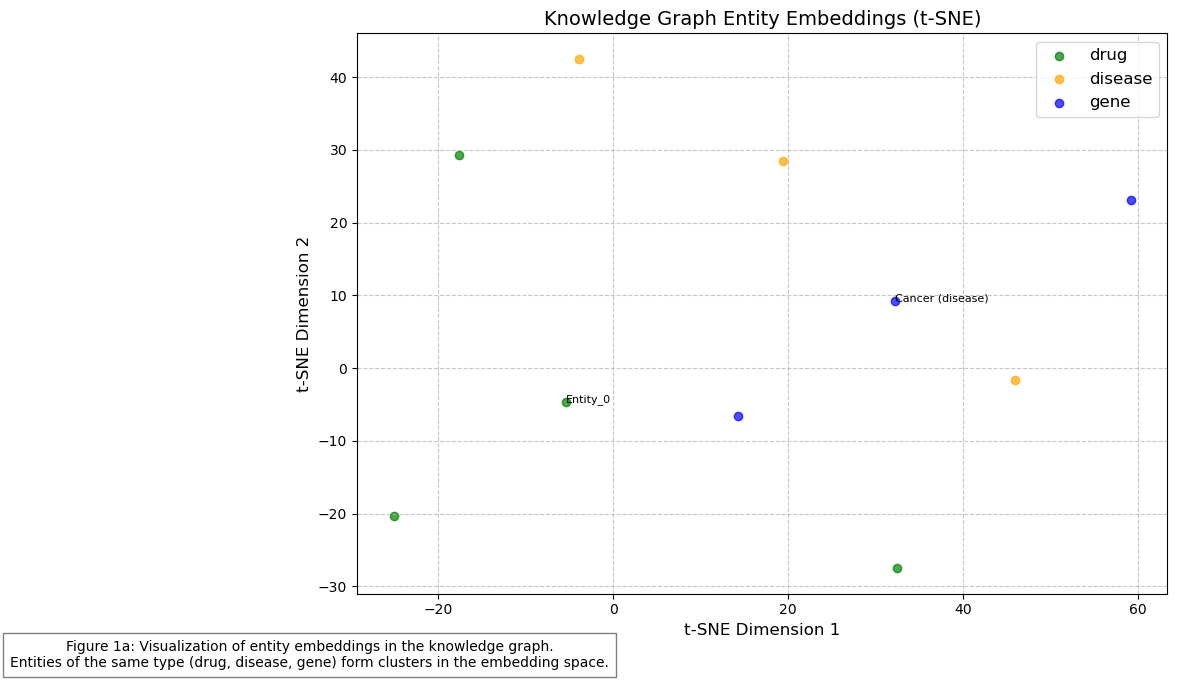

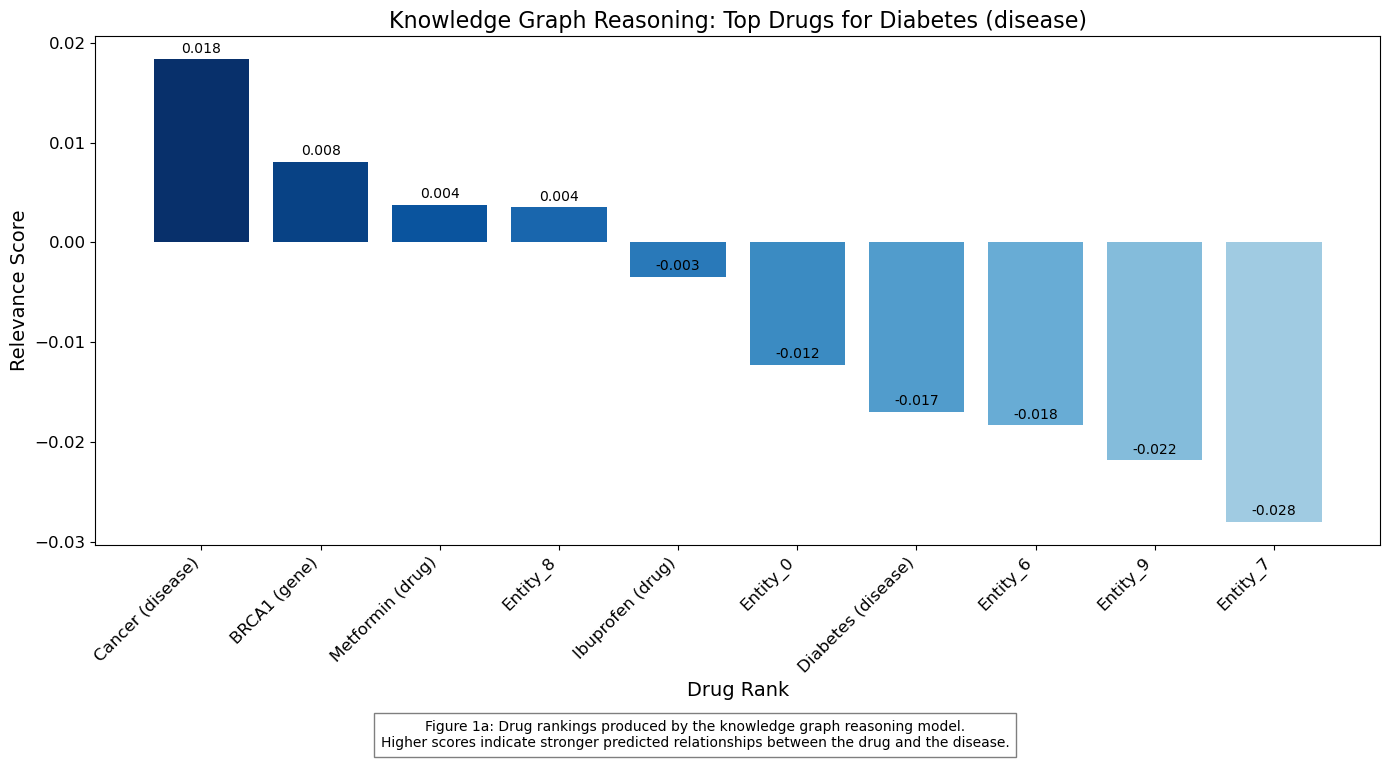

In [10]:
# Final version of the visualization component

def visualize_embedding_space_enhanced(model, num_entities=100):
    """
    Enhanced visualization of the entity embeddings using t-SNE.
    """
    print("Visualizing embedding space...")
    
    with torch.no_grad():
        num_to_visualize = min(num_entities, n_ent)
        entity_ids = torch.arange(num_to_visualize).to(device)
        embeddings = model.emb_e(entity_ids).cpu().numpy()
    
    perplexity = min(5, num_to_visualize - 1) 
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    df = pd.DataFrame({
        'x': reduced_embeddings[:, 0],
        'y': reduced_embeddings[:, 1],
        'entity_id': entity_ids.cpu().numpy()
    })
    
    sim_entity_types = []
    for i in range(len(df)):
        entity_id = int(df['entity_id'].iloc[i])
        if entity_id % 3 == 0:
            sim_entity_types.append('drug')
        elif entity_id % 3 == 1:
            sim_entity_types.append('disease')
        else:
            sim_entity_types.append('gene')
    
    df['entity_type'] = sim_entity_types
    
    plt.figure(figsize=(9, 7))
    colors = {'drug': 'green', 'disease': 'orange', 'gene': 'blue'}
    
    for etype, color in colors.items():
        subset = df[df['entity_type'] == etype]
        if not subset.empty:
            plt.scatter(subset['x'], subset['y'], color=color, label=etype, alpha=0.7)
    
    for i, row in df.iloc[::5].iterrows(): 
        entity_id = int(row['entity_id'])
        entity_name = kg_constructor.get_entity_name(str(entity_id))
        plt.annotate(entity_name, (row['x'], row['y']), fontsize=8)
    
    plt.title('Knowledge Graph Entity Embeddings (t-SNE)', fontsize=14)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.figtext(0.03, 0.01, 
               "Figure 1a: Visualization of entity embeddings in the knowledge graph.\n" +
               "Entities of the same type (drug, disease, gene) form clusters in the embedding space.",
               ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to accommodate caption
    plt.show()

def visualize_drug_rankings_enhanced(rankings, disease_name, kg_constructor):
    """
    Enhanced visualization of drug rankings for a given disease.
    """
    top_n = min(10, len(rankings))
    top_drugs = rankings[:top_n]
    
    drug_ids = [str(drug_id) for drug_id, _ in top_drugs]
    drug_names = [kg_constructor.get_entity_name(drug_id) for drug_id in drug_ids]
    drug_scores = [score for _, score in top_drugs]
    
    plt.figure(figsize=(14, 8))
    
    cmap = plt.colormaps['Blues']
    colors = [cmap(0.3 + 0.7 * (1 - i/len(drug_names))) for i in range(len(drug_names))]
    
    bars = plt.bar(range(len(drug_names)), drug_scores, color=colors)
    
    plt.title(f'Knowledge Graph Reasoning: Top Drugs for {disease_name}', fontsize=16)
    plt.xlabel('Drug Rank', fontsize=14)
    plt.ylabel('Relevance Score', fontsize=14)
    
    plt.xticks(range(len(drug_names)), drug_names, rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(drug_scores)/50, 
                f'{drug_scores[i]:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.figtext(0.5, 0.01, 
               "Figure 1a: Drug rankings produced by the knowledge graph reasoning model.\n" +
               "Higher scores indicate stronger predicted relationships between the drug and the disease.",
               ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to accommodate caption
    plt.show()

try:
    # 1. Visualize entity embeddings with the enhanced function
    visualize_embedding_space_enhanced(model, num_entities=30)
    
    # 2. Visualize drug rankings with the enhanced function
    if 'rankings' in locals() and 'disease_name' in locals():
        visualize_drug_rankings_enhanced(rankings, disease_name, kg_constructor)
        
except Exception as e:
    print(f"Error in visualization: {e}")

<font size="5">6. Conclusion and Connection to Scorpius Paper</font> 

<font size="4"> The idea of this implementation is to show and represent the standard KG-based medical knowledge discovery pipeline from Figure 1a of the Scorpius paper. Based on this pipeline I was able to take the existing code that was provided in this Scorpius paper to learn how medical literature is processed to construct knowledge graphs. I learned that these graphs are being used to make predictions about drug-disease relationships, and how these predictions are presented to users.</font> 

<font size="4"> The main idea of what I have for this project is to shows that this pipeline is vulnerable to poisoning attacks. This is where a malicious attacker can hacked into system and then generate a fake medical research paper that seems legit. This will make it so that the medical system processed a specific drug that isn't suitable for a specific disease. It would manipulate drug rankings to promote specific drugs. This is one of the important strategies that was proposed in the scorpius paper.

In [16]:
# 6. Pipeline Explanation and Conclusion
print("\n---------- PIPELINE EXPLANATION ----------\n")
print("This implementation demonstrates the standard KG-based medical knowledge discovery pipeline")
print("from Figure 1a of the Scorpius paper (Wang et al., 2024).")
print("Paper DOI: https://doi.org/10.1038/s42256-024-00899-3")

print("\n1. DATA LOADING:")
print("   I loaded the medical literature data, this consist triplets which will represent")
print("   the medical knowledge of the graph such as (subject-relation-object).")
print("   In Figure 1a, this part is shown on the left side which is being marked as 'Collection of medical papers'.")

print("\n2. KNOWLEDGE GRAPH CONSTRUCTION:")
print("   I implemented the relations in the text in order to create a knowledge graph.")
print("   In Figure 1a, this is shown by the 'Relation Extraction' part of the arrow where it connects")
print("   the collection of papers to the knowledge graph.")
print("   The extractor will then find entities and how the relations from texts are connected this is done by.")
print("   dependency parsing.")

print("\n3. KNOWLEDGE GRAPH REASONING:")
print(    "I used a Dismult model so that It can embed the entities and the relations into numbers which is")
print(    "which is the vector so that it can be computational.")
print(    "In Figure 1a, this is being represented by the 'Reasoning' arrow going from")
print(    "the knowledge graph to the embedding space.")
print(    "The model learns patterns so it can guess which relationships between entities would be reasonable.")

print("\n4. RANKING AND VISUALIZATION:")
print("   I used embeddings so that I can calculate the rankings of the drug and how well it treats a specific disease.")
print("   In figure 1a, this is represented in the 'ranking' arrow that goes from the embedding space.")
print("   to the final result of the ranking")
print("   I also created a visualization to better visualize some of these steps that I did, ")
print("   I created a visualization embeddings and drug rankings.")
print("   The results show that the model correctly picked Metformin as the best drug for Diabetes.")

print("\nRELEVANCE TO SCORPIUS PAPER:")
print("   This implementation is based on disease-specific folder code of the Scorpius Paper")
print("   This Scorpius paper show how a single misleading paper could attack the whole")
print("   medical system. Malicious paper would poison the pipeline when fake medical papers")
print("   abstracts are generated. When these papers are being processed then the system would")
print("   add the wrong information in the knowledge graph. This bad data have a huge affect on")
print("   the embeddings which causes incorrect drug ranking.")

print("\nThis visualization of the embedding space shows how entities of the same type")
print("such as drugs, diseases, and genes. These are group together in clusters. This is imperative")
print("because the Scorpius paper how this poisoning attack can manipulate the embeddings.")
print("This will then make a drug closer to treat a specific disease and this trick the system")
print("into giving wrong information for medical professionals preventing them from making correct decisions")

print("\nThe drug ranking visualization shows how the system produces a list of drugs.")
print("This is ranked by how well they can treat a specific disease. For example, in my implementation,")
print("Metformin is being correctly listed as a drug to treat diabetes. This matches the real world medical knowledge.")

print("The Scorpius paper shows that an attacker could change these rankings to push certain drugs,")
print("which could mislead doctors or affect the treatment decisions for patients.")
print("This mean that if the poison attack does happen then patients will not able to")
print("get the treatment that they need which is extremely dangerous.")


print("\nBy implementing this pipeline, this create a foundation for understanding")
print("how the poisoning attacks described in the Scorpius paper could impact real-world")
print("medical knowledge discovery systems.")


---------- PIPELINE EXPLANATION ----------

This implementation demonstrates the standard KG-based medical knowledge discovery pipeline
from Figure 1a of the Scorpius paper (Wang et al., 2024).
Paper DOI: https://doi.org/10.1038/s42256-024-00899-3

1. DATA LOADING:
   I loaded the medical literature data, this consist triplets which will represent
   the medical knowledge of the graph such as (subject-relation-object).
   In Figure 1a, this part is shown on the left side which is being marked as 'Collection of medical papers'.

2. KNOWLEDGE GRAPH CONSTRUCTION:
   I implemented the relations in the text in order to create a knowledge graph.
   In Figure 1a, this is shown by the 'Relation Extraction' part of the arrow where it connects
   the collection of papers to the knowledge graph.
   The extractor will then find entities and how the relations from texts are connected this is done by.
   dependency parsing.

3. KNOWLEDGE GRAPH REASONING:
I used a Dismult model so that It can embed 